## Run MCMC inference using PriorCVAE_Matern12 model

In [1]:
import random
import time
import os
import yaml

import tikzplotlib
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro.distributions as npdist
import numpyro
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
import pickle

import jax.config as config
config.update("jax_enable_x64", True)

#from priorCVAE.priors import Matern12 , Matern52, SquaredExponential
from experiments.zimbabwe.zimbabwe_utility import read_data

numpyro.set_host_device_count(4)

import flax.linen as nn
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params

In [2]:
data_path = "../data/zwe2016phia.geojson"
num_warmup = 2000
num_samples = 10000
num_chains = 2

## Load Data

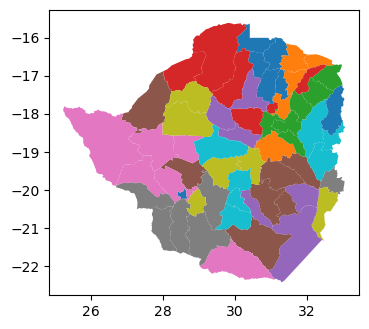

In [3]:
data = gpd.read_file(data_path)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
data.plot(column='area_id', ax=ax, legend=False)

plt.show()

In [4]:
x, data_centroid = read_data(data_path, normalize=True)

/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_frame["centroid"] = data_frame["geometry"].centroid
/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = data_frame["geometry"].centroid


In [5]:
## Adding estimate data
data_centroid["estimate"] = data["estimate"]

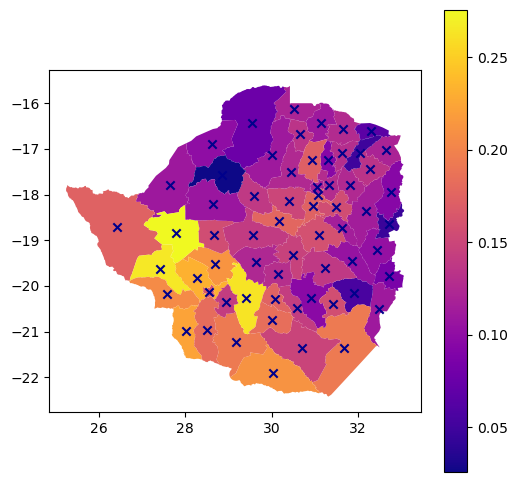

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
data_centroid.plot(column='estimate', ax=ax, legend=True, cmap='plasma')
data_centroid["centroid"].plot(ax=ax, color="DarkBlue", marker="x")
plt.show()

## Define model - PriorCVAE

In [7]:
output_dir = "../outputs/b5xpod37"
data_path = "../data/zwe2016phia.geojson"
n_samples = 1000

In [8]:
cfg_path = os.path.join(output_dir, ".hydra", "config.yaml")
with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

conditional = cfg_data["conditional"]
latent_dim = cfg_data["latent_dim"]
normalize = cfg_data["normalize"]
dec_activation_fn = cfg_data["dec_activation"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

In [9]:
trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

In [45]:
def model_centroids(latent_dim, n_obs=None, y=None, lengthscale=None):
    
    # fixed effects
    #b0 = numpyro.sample('b0', npdist.Normal(0, 1))

    #lengthscale = numpyro.sample("lengthscale", npdist.Gamma(2,4)) 
    if lengthscale is None:
        lengthscale = numpyro.sample("lengthscale", npdist.Uniform(0,1)) 
    
    c = jnp.array([lengthscale])

    kernel_var = 0.77 #numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
    
    z = numpyro.sample("z", npdist.Normal(jnp.zeros(latent_dim), jnp.ones(latent_dim)))
    z = jnp.concatenate([z, c]) 
    f = numpyro.deterministic('f', decoder.apply({'params': trained_decoder_params}, z))
     
    re = numpyro.deterministic('re', kernel_var * f)
    
    # linear predictor
    #
    lp = re
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))
    
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

## Observations

In [24]:
data['y'] = round(data['y']).astype(int)
data['n_obs'] = round(data['n_obs']).astype(int)

## GP Prior

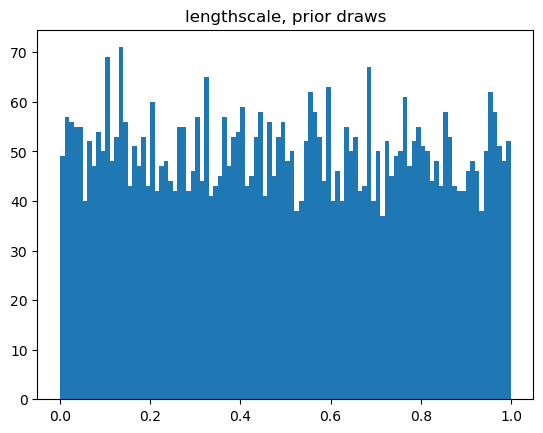

In [26]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))
gp_predictive = Predictive(model_centroids, num_samples=5000)
gp_preds = gp_predictive(rng_key_, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs))

ls_prior_draws = gp_preds['lengthscale']
plt.hist(ls_prior_draws, bins=100)
plt.title('lengthscale, prior draws')
plt.show()

# kernel_var_prior = gp_preds['variance']
# plt.hist(kernel_var_prior, bins=100)
# plt.title('var, prior draws')
# plt.show()

## MCMC Inference using PriorCVAE-Matern12 prior

In [27]:
fname = 'zimbabwe_cvae_mcmc_Matern12.pkl'

rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(random.randint(0, 999999)))

# inference
start = time.time()
kernel = NUTS(model_centroids)
mcmc_gp = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc_gp.run(rng_key, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y))
t_elapsed = time.time() - start

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

In [28]:
with open(fname, 'wb') as f:
    pickle.dump(mcmc_gp, f)

In [29]:
mcmc_gp.print_summary(exclude_deterministic=True)



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.48      0.25      0.46      0.09      0.93  13460.19      1.00
         z[0]      0.02      1.00      0.03     -1.66      1.60  45722.81      1.00
         z[1]     -0.07      0.98     -0.07     -1.64      1.58  44302.87      1.00
         z[2]     -0.03      0.99     -0.03     -1.68      1.56  44804.01      1.00
         z[3]      0.07      1.00      0.06     -1.57      1.69  44615.66      1.00
         z[4]     -0.00      1.00     -0.01     -1.64      1.63  43960.09      1.00
         z[5]      0.03      0.99      0.04     -1.61      1.65  43186.48      1.00
         z[6]     -0.01      1.00     -0.01     -1.68      1.63  42870.86      1.00
         z[7]      0.04      1.00      0.05     -1.63      1.66  44467.39      1.00
         z[8]     -0.18      1.01     -0.18     -1.85      1.50  43255.52      1.00
         z[9]     -0.07      1.00     -0.07     -1.76      1.55  41769.12  

In [30]:
mcmc_gp_samples = mcmc_gp.get_samples()

In [31]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc_gp.get_samples(group_by_chain=True))
r = jnp.mean(ss['re']['n_eff'])
print("Average ESS for all REs : " + str(round(r)))


MCMC elapsed time: 3 s
Average ESS for all REs : 30464


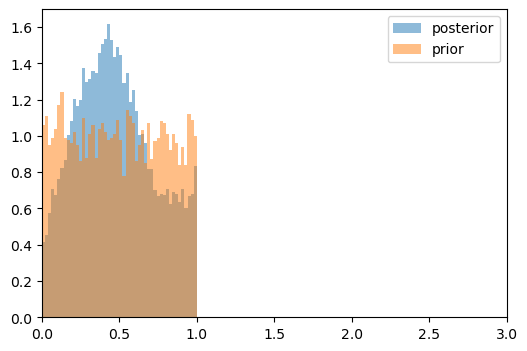

In [32]:
c_samps_gp = mcmc_gp_samples['lengthscale']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(c_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('lengthscale, prior and posterior')
plt.legend()
plt.xlim([0, 3])

tikzplotlib.save(r"lengthscale.tex",
                 figurewidth='\\figurewidth', figureheight='\\figureheight',
                 figure=fig)

plt.show()

In [33]:
var_samps_gp = mcmc_gp_samples['variance']
plt.hist(var_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('kernel_var, prior and posterior')
plt.legend()
plt.xlim(0,3)

tikzplotlib.save(r"variance.tex",
                 figurewidth='\\figurewidth', figureheight='\\figureheight',
                 figure=fig)

plt.show()

KeyError: 'variance'

(24.8460406, 33.4588074, -22.7626307, -15.268733300000001)

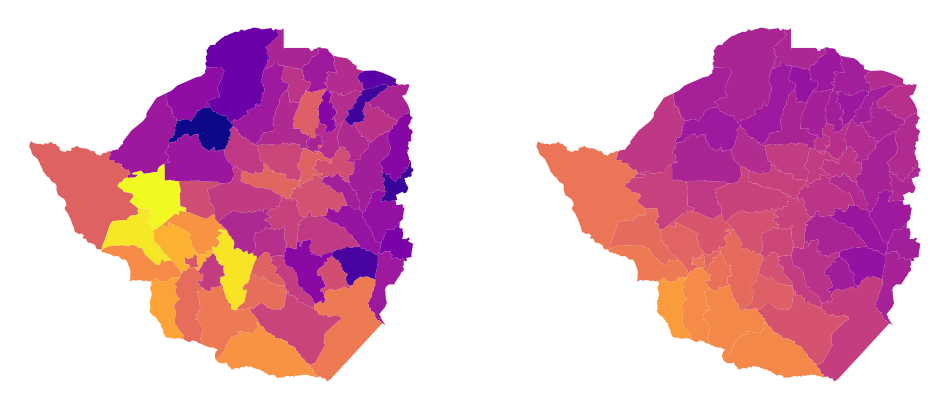

In [34]:
# posterior predictive
posterior_predictive = Predictive(model_centroids, mcmc_gp_samples)(jax.random.PRNGKey(random.randint(0, 9999)), 
                                                                         latent_dim=latent_dim, 
                                                                         n_obs = jnp.array(data.n_obs))


theta_samps_gp = posterior_predictive['theta']
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = jnp.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = jnp.quantile(theta_samps_gp, 0.75, axis=0)

data['theta_gp'] = theta_mean_gp

theta_observed = jnp.array(data['estimate'])
theta_estimated_gp = jnp.array(data['theta_gp'])

_max = np.max([theta_observed, theta_estimated_gp])
_min = np.min([theta_observed, theta_estimated_gp])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
data.plot(column="estimate", ax=ax[0], cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_gp", ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)

ax[0].axis("off")
ax[1].axis("off")

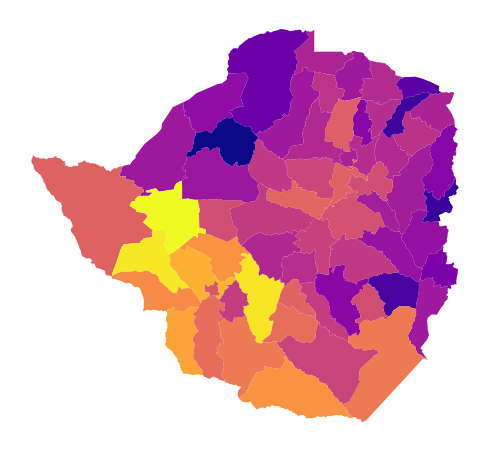

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)
# data.plot(column="theta_gp", ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)

plt.axis("off")
plt.tight_layout()
plt.savefig("estimate.pdf")
plt.show()

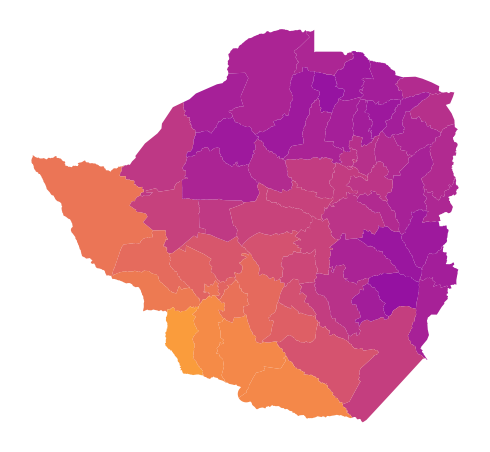

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data.plot(column="theta_gp", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

plt.axis("off")
plt.tight_layout()
plt.savefig("gp_inference.pdf")
plt.show()

In [46]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))

cvae_predictive = Predictive(model_centroids, num_samples=100)
cvae_preds_map  = cvae_predictive(rng_key_, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), 
                                  lengthscale = 0.1)

In [47]:
cvae_preds_map_f = cvae_preds_map['f']

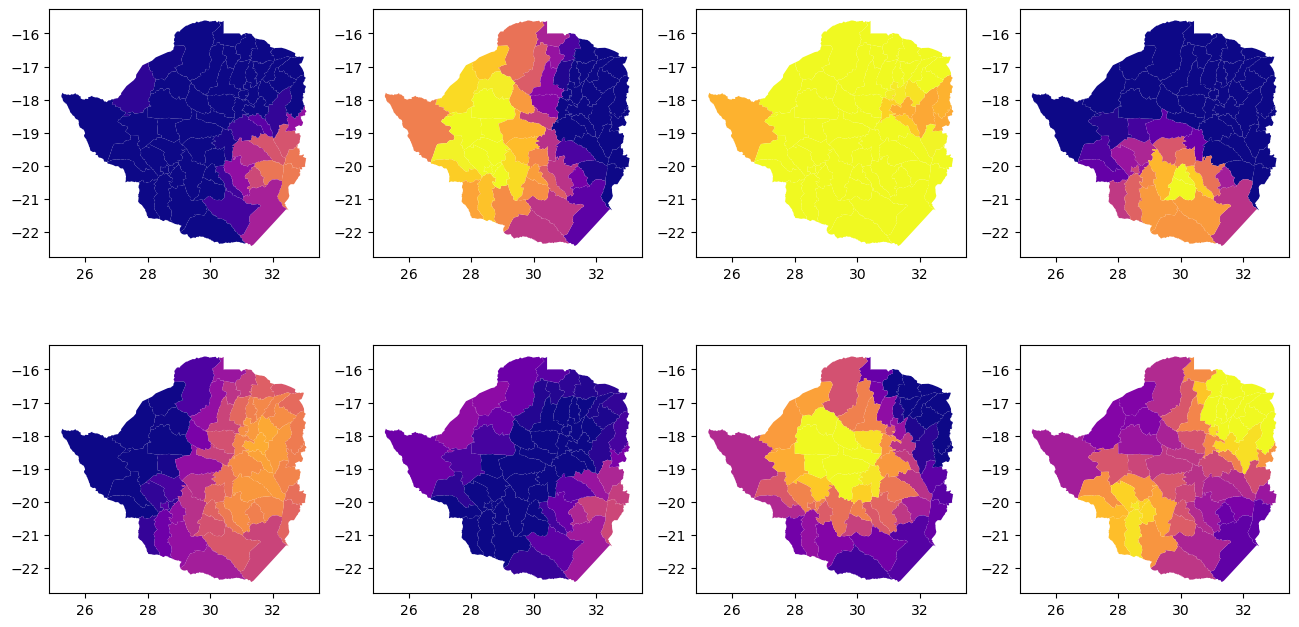

In [49]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    rows = int(i//4)
    cols = int(i%4)
    
    data['f' + str(i)] = cvae_preds_map_f[i, :]

    data.plot(column='f' + str(i),   ax=axs[rows][cols], cmap='plasma', vmin=0, vmax =1)